In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils, to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/fire-dataset
/kaggle/input/fire-dataset/fire_dataset
/kaggle/input/fire-dataset/fire_dataset/non_fire_images
/kaggle/input/fire-dataset/fire_dataset/fire_images


In [2]:
#copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

#copy the Xception models
!cp ../input/keras-pretrained-models/xception* ~/.keras/models/
#show
!ls ~/.keras/models

cp: cannot stat '../input/keras-pretrained-models/xception*': No such file or directory


In [3]:
base_folder = '../input/fire-dataset'
data_folder = '../input/fire-dataset/fire_dataset'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [4]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    print(class_folder)
    label = category
    image_count[category] = []
    #print(image_count)
    
    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category,path), i, category])

2it [00:00, 447.08it/s]

../input/fire-dataset/fire_dataset/fire_images
../input/fire-dataset/fire_dataset/non_fire_images


In [5]:
for key, value in image_count.items():
    print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [6]:
df = pd.DataFrame(train_data, columns=['file','id','label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.743.png,0,fire_images
1,fire_images/fire.717.png,0,fire_images
2,fire_images/fire.157.png,0,fire_images
3,fire_images/fire.26.png,0,fire_images
4,fire_images/fire.314.png,0,fire_images


Image Preprocessing

In [7]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask=mask)
    return output/255

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0,0),3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5,0)
    return image_sharp


def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

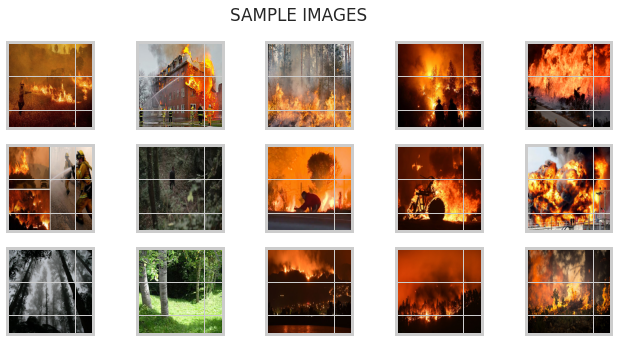

In [8]:
nb_rows = 3
nb_cols = 5

fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10,5));
plt.suptitle('SAMPLE IMAGES');

for i in range(0,nb_rows):
    for j in range(0,nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255,)))/255.);

plt.show();

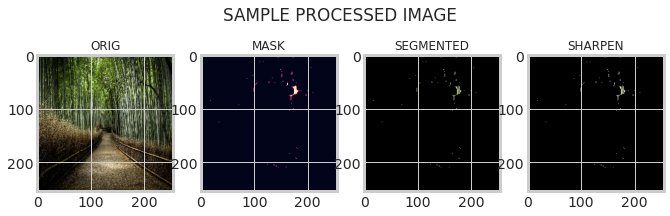

In [9]:
img = read_img(df['file'][998],(255,255))

image_mask = create_mask_for_plant(img)

image_segmented = segment_image(img)

image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10,5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
#plt.tight_layout(1)

ax[0].set_title('ORIG', fontsize=12)
ax[1].set_title('MASK', fontsize=12)
ax[2].set_title('SEGMENTED', fontsize=12)
ax[3].set_title('SHARPEN', fontsize=12)

ax[0].imshow(img/255);
ax[1].imshow(image_mask);
ax[2].imshow(image_segmented);
ax[3].imshow(image_sharpen);


XCEPTION BOTTLENECK FEATURE EXTRACTION

In [10]:
len(df)
df.tail()
df.shape[1]

999

,file,id,label
994,non_fire_images/non_fire.162.png,1,non_fire_images
995,non_fire_images/non_fire.190.png,1,non_fire_images
996,non_fire_images/non_fire.9.png,1,non_fire_images
997,non_fire_images/non_fire.107.png,1,non_fire_images
998,non_fire_images/non_fire.223.png,1,non_fire_images


3

In [11]:
INPUT_SIZE = 255

X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype='float')
for i, file in tqdm(enumerate(df['file'])):
    img = read_img(file,(INPUT_SIZE,INPUT_SIZE))
    
    image_segmented = segment_image(img)
    
    image_sharpen = sharpen_image(image_segmented)
    
    x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis=0))
    X_train[i]=x

999it [00:50, 19.96it/s]


In [12]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (999, 255, 255, 3)
Train Image Size:  194879925


In [13]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [14]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 30s 4s/step


In [15]:
model = Sequential()
model.add(Dense(units = 256, activation = 'relu', input_dim = bf_train_x.shape[1]))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(bf_train_x, y_train, epochs=100, batch_size=32);

Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 0.5711 - accuracy: 0.7456
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4969 - accuracy: 0.7586
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4244 - accuracy: 0.7894
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3703 - accuracy: 0.8435
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3447 - accuracy: 0.8474
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3253 - accuracy: 0.8568
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2836 - accuracy: 0.8726
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2776 - accuracy: 0.8799
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8755
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.2374 - accuracy: 0.8894
Epoch 11/

25/25 [==============================] - 0s 3ms/step - loss: 0.0885 - accuracy: 0.9647
Epoch 84/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1677 - accuracy: 0.9035
Epoch 85/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1654 - accuracy: 0.9351
Epoch 86/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0966 - accuracy: 0.9684
Epoch 87/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0983 - accuracy: 0.9654
Epoch 88/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0886 - accuracy: 0.9647
Epoch 89/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0887 - accuracy: 0.9612
Epoch 90/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0872 - accuracy: 0.9620
Epoch 91/100
25/25 [==============================] - 0s 3ms/step - loss: 0.1430 - accuracy: 0.9365
Epoch 92/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0874 - accuracy: 0.9671
Epoch 93/100


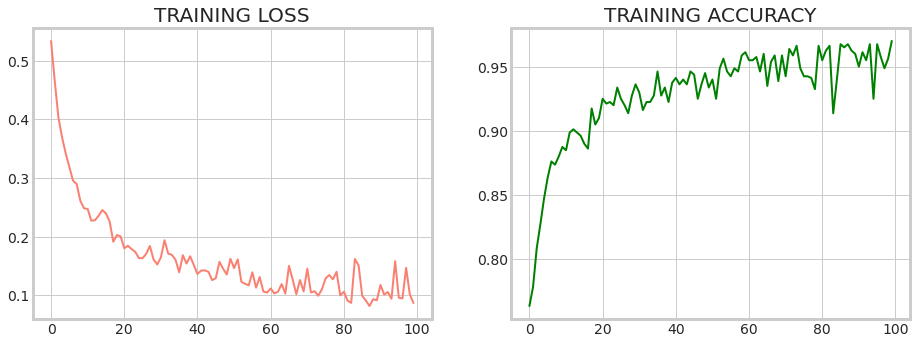

In [17]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [20]:
predictions = model.predict_classes(bf_train_val)

In [21]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       145
           1       0.85      0.84      0.84        55

    accuracy                           0.92       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.91      0.92      0.91       200



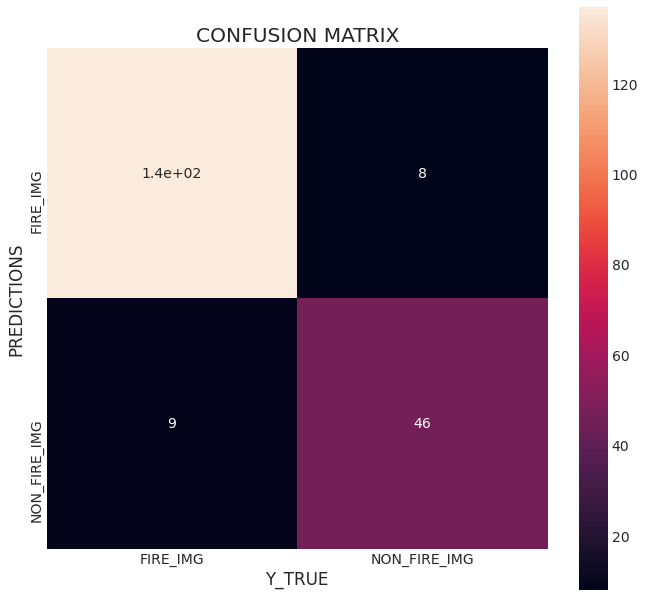

In [22]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, square=True, annot=True,
            yticklabels=['FIRE_IMG', 'NON_FIRE_IMG'],
            xticklabels=['FIRE_IMG', 'NON_FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");